In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
from torchvision.models import vgg16
from HSI_class import HSI
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import zeroPadding
import torch.nn.functional as F

import time
start_time = time.time()

# Check if GPU is available
print("GPU Available:", torch.cuda.is_available())

# If available, print the GPU name
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

GPU Available: True
GPU Name: NVIDIA GeForce GTX 1650


In [2]:
dataset_path = r"C:\Users\Asus TUF\Documents\code\TA\Hyperspectral oil spill detection datasets"

datasets = []

i = 0
for filename in os.listdir(dataset_path):
    if i>9:
        break
    file_path = os.path.join(dataset_path, filename)
    if os.path.isfile(file_path):  # Check if it's a file
        print(f"Processing file: {file_path}")
        hsi = HSI(file_path)
        datasets.append(hsi)
    i += 1

Processing file: C:\Users\Asus TUF\Documents\code\TA\Hyperspectral oil spill detection datasets\GM01.mat
Processing file: C:\Users\Asus TUF\Documents\code\TA\Hyperspectral oil spill detection datasets\GM02.mat
Processing file: C:\Users\Asus TUF\Documents\code\TA\Hyperspectral oil spill detection datasets\GM03.mat
Processing file: C:\Users\Asus TUF\Documents\code\TA\Hyperspectral oil spill detection datasets\GM04.mat
Processing file: C:\Users\Asus TUF\Documents\code\TA\Hyperspectral oil spill detection datasets\GM05.mat
Processing file: C:\Users\Asus TUF\Documents\code\TA\Hyperspectral oil spill detection datasets\GM06.mat
Processing file: C:\Users\Asus TUF\Documents\code\TA\Hyperspectral oil spill detection datasets\GM07.mat
Processing file: C:\Users\Asus TUF\Documents\code\TA\Hyperspectral oil spill detection datasets\GM08.mat
Processing file: C:\Users\Asus TUF\Documents\code\TA\Hyperspectral oil spill detection datasets\GM09.mat
Processing file: C:\Users\Asus TUF\Documents\code\TA\Hy

In [3]:
def testWithDataset(n): 
    hsi_test = datasets[n]

    test_img = hsi_test.img
    test_gt = hsi_test.gt

    patch_size = 9
    half_patch = patch_size // 2

    height = test_img.shape[0]
    width = test_img.shape[1]

    matrix=zeroPadding.zeroPadding_3D(test_img,half_patch) #add 0 in every side of the data
    print(f"img shape: {test_img.shape}")
    print(f"img shape after padding {matrix.shape}")
    print(f"number of pixel {width * height}")

    print(f"ground truth shape: {test_gt.shape}")

    indices0 = np.argwhere(test_gt == 0)
    indices1 = np.argwhere(test_gt == 1)

    print(f"indices = 0 shape: {indices0.shape}")
    print(f"indices = 1 shape: {indices1.shape}")

    num_samples = 5000

    random_indices0 = indices0[np.random.choice(len(indices0), num_samples, replace=False)]
    random_indices1 = indices1[np.random.choice(len(indices1), num_samples, replace=False)]

    test_indices = np.vstack((random_indices0, random_indices1))

    print(test_indices.shape)

    return test_indices, test_gt, matrix

In [4]:
import createSample as CS

hsi_ = datasets[0]
patch_size = 9
sample_per_class = 50

indices_0 = []
indices_1 = []
random = 0
print(f"random: {random}")

if random:
    print("generating random sample")
    selected_patch_0, selected_patch_1, indices_0, indices_1 = CS.createSample(hsi_, patch_size, sample_per_class)
else:
    print("using generated indices")
    indices_0 = [(np.int64(526), np.int64(187)), (np.int64(537), np.int64(71)), (np.int64(496), np.int64(222)), (np.int64(1200), np.int64(102)), (np.int64(1178), np.int64(413))]
    indices_1 = [(np.int64(174), np.int64(66)), (np.int64(382), np.int64(580)), (np.int64(1202), np.int64(171)), (np.int64(469), np.int64(254)), (np.int64(267), np.int64(228))]

    selected_patch_0, selected_patch_1 = CS.getSample(hsi_, patch_size, sample_per_class, indices_0, indices_1)


i =0
half_patch = patch_size // 2
# print(hsi_.img[indices_0[i][0]][indices_0[i][1]])
# print(selected_patch_0[i][half_patch][half_patch])

# print(hsi_.img[indices_1[i][0]][indices_1[i][1]])
# print(selected_patch_1[i][half_patch][half_patch])
# i =4
# half_patch = patch_size // 2
# print(hsi_.img[indices_0[i][0]][indices_0[i][1]])
# print(selected_patch_0[i][half_patch][half_patch])

# print(hsi_.img[indices_1[i][0]][indices_1[i][1]])
# print(selected_patch_1[i][half_patch][half_patch])

indices = indices_0 +  indices_1

# Concatenating along axis 0
x_train = np.concatenate((selected_patch_0, selected_patch_1), )

y_train = np.array([])

gt = hsi_.gt
for indice in indices:
    # print(gt[indice[0]][indice[1]])
    y_train = np.append(y_train, gt[indice[0]][indice[1]])

count = np.count_nonzero(y_train == 0)  # Count elements equal to 0
print(f'number of element equal 0 {count}')

count = np.count_nonzero(y_train == 1)  # Count elements equal to 1
print(f'number of element equal 1 {count}')



# Print shape to verify
print(f"x_train shape: {x_train.shape}")  # Expected output: (10, 9, 9, 224)
print(f"y_train shape: {y_train.shape}") 


random: 0
using generated indices
hsi shape
(1243, 684, 224)
indices 0 used: [(np.int64(526), np.int64(187)), (np.int64(537), np.int64(71)), (np.int64(496), np.int64(222)), (np.int64(1200), np.int64(102)), (np.int64(1178), np.int64(413))]
indices 1 used: [(np.int64(174), np.int64(66)), (np.int64(382), np.int64(580)), (np.int64(1202), np.int64(171)), (np.int64(469), np.int64(254)), (np.int64(267), np.int64(228))]
number of element equal 0 5
number of element equal 1 5
x_train shape: (10, 9, 9, 224)
y_train shape: (10,)


In [5]:
import augmentation as aug
n_category = 2
band_size = 224
num_per_category_augment_1 = 10
num_per_category_augment_2 = 10

data_augment1, label_augment1 = aug.Augment_data(x_train, y_train, n_category, patch_size, band_size, num_per_category_augment_1)

data_augment2, label_augment2 = aug.Augment_data2(x_train, y_train, n_category, patch_size, band_size, num_per_category_augment_2)

print(f"hasil augmentasi 1 shape: {data_augment1.shape}")
print(f"label augmentai 1 shape: {label_augment1.shape}")

print(f"hasil augmentasi 2 shape: {data_augment2.shape}")
print(f"label augmentasi 2 shape: {label_augment2.shape}")

print(label_augment1)
print(label_augment2)

# # Count occurrences of each unique element
# counts1 = np.bincount(label_augment1)

# # Print results
# for i, count in enumerate(counts1):
#     print(f"Element {i} occurs {count} times.")

# counts2 = np.bincount(label_augment2)

# # Print results
# for i, count in enumerate(counts2):
#     print(f"Element {i} occurs {count} times.")

# print(label_augment1[3])

data_augment = np.concatenate((data_augment1, data_augment2))
label_augment = np.concatenate((label_augment1, label_augment2))

print(f"hasil augmentasi gabungan untuk training: {data_augment.shape}")
print(f"label augmentasi gabungan: {label_augment.shape}")

# print(label_augment)

# Count occurrences of each unique element
counts = np.bincount(label_augment)

# Print results
for i, count in enumerate(counts):
    print(f"Element {i} occurs {count} times.")

hasil augmentasi 1 shape: (20, 9, 9, 224)
label augmentai 1 shape: (20,)
hasil augmentasi 2 shape: (20, 9, 9, 224)
label augmentasi 2 shape: (20,)
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
hasil augmentasi gabungan untuk training: (40, 9, 9, 224)
label augmentasi gabungan: (40,)
Element 0 occurs 20 times.
Element 1 occurs 20 times.


In [6]:
# # import torch
# # import torch.nn as nn
# import torch.nn.functional as F

# class ConvTo2D(nn.Module):
#     def __init__(self):
#         super(ConvTo2D, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=224, out_channels=64, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
#         self.pool = nn.AdaptiveAvgPool2d((3, 3))  # control output spatial size (e.g. 3x3)

#     def forward(self, x):
#         x = F.relu(self.conv1(x))      # -> (batch, 64, 9, 9)
#         x = F.relu(self.conv2(x))      # -> (batch, 128, 9, 9)
#         x = self.pool(x)               # -> (batch, 128, 3, 3)
#         x = x.permute(0, 2, 3, 1)      # -> (batch, 3, 3, 128)
#         x = x.reshape(x.size(0), -1, 128)  # -> (batch, 9, 128) == (batch, n1, n2)
#         return x

# feature_extractor = ConvTo2D()

In [7]:
print(data_augment.shape)
print(label_augment.shape)

x_data = data_augment 
y_labels = label_augment

x_data = torch.tensor(x_data)
x_data = x_data.to(torch.float32)
x_data = x_data.permute(0, 3, 1, 2)
print(f"X_train shape: {x_data.shape}")

# feature_extractor = ConvTo2D()
# with torch.no_grad():  # No gradient needed for feature extraction
#     features = feature_extractor(x_data)  # (100, 128)
features_np = x_data.numpy() 

    

print(features_np.shape)

(40, 9, 9, 224)
(40,)
X_train shape: torch.Size([40, 224, 9, 9])
(40, 224, 9, 9)


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

X = features_np
y = y_labels
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, random_state=42)

print(y_train)
print(y_val)

[0 1 0 0 0 0 1 1 0 1 0 1 1 0 1 0 0 1 0 1]
[1 1 1 0 0 1 1 0 1 0 0 0 1 1 1 0 1 0 0 1]


In [9]:
import torch.nn as nn
import torch.nn.functional as F

class HybridSN_Binary(nn.Module):
    def __init__(self, input_channels=1, spectral_bands=224, height=9, width=9):
        super(HybridSN_Binary, self).__init__()

        self.conv3d_1 = nn.Conv3d(input_channels, 8, kernel_size=(3, 3, 7), padding=(1, 1, 3))
        self.conv3d_2 = nn.Conv3d(8, 16, kernel_size=(3, 3, 5), padding=(1, 1, 2))
        self.conv3d_3 = nn.Conv3d(16, 32, kernel_size=(3, 3, 3), padding=(1, 1, 1))

        self.conv2d = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1)

        self.flattened_size = 64 * height * width

        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)  # single output neuron for binary classification

    def forward(self, x):
        x = F.relu(self.conv3d_1(x))
        x = F.relu(self.conv3d_2(x))
        x = F.relu(self.conv3d_3(x))

        # Squeeze spectral dim to get shape (B, 32, H, W)
        x = x[:, :, x.shape[2] // 2, :, :]

        x = F.relu(self.conv2d(x))

        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # no activation here — BCEWithLogitsLoss expects raw logits

        return x.squeeze(1)  # output shape (B,)


In [10]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

print(X_train_tensor.shape)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor )
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)

input_channels = X_train_tensor.shape[1]
print(input_channels)

torch.Size([20, 1, 224, 9, 9])
1


In [11]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HybridSN_Binary(input_channels=1, spectral_bands=224, height=9, width=9)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(100):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        labels = labels.squeeze(1)
        # print(labels.shape)
        # print(labels)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/100, Loss: {loss.item():.4f}")


Epoch 1/100, Loss: 27.2548
Epoch 2/100, Loss: 24.1082
Epoch 3/100, Loss: 24.5579
Epoch 4/100, Loss: 23.3683
Epoch 5/100, Loss: 22.2175
Epoch 6/100, Loss: 21.7425
Epoch 7/100, Loss: 22.0606
Epoch 8/100, Loss: 21.8059
Epoch 9/100, Loss: 21.6315
Epoch 10/100, Loss: 21.6356
Epoch 11/100, Loss: 21.6697
Epoch 12/100, Loss: 21.6510
Epoch 13/100, Loss: 21.6172
Epoch 14/100, Loss: 21.6098
Epoch 15/100, Loss: 21.6237
Epoch 16/100, Loss: 21.6306
Epoch 17/100, Loss: 21.6243
Epoch 18/100, Loss: 21.6132
Epoch 19/100, Loss: 21.6056
Epoch 20/100, Loss: 21.6066
Epoch 21/100, Loss: 21.6115
Epoch 22/100, Loss: 21.6124
Epoch 23/100, Loss: 21.6073
Epoch 24/100, Loss: 21.6013
Epoch 25/100, Loss: 21.5988
Epoch 26/100, Loss: 21.5998
Epoch 27/100, Loss: 21.6003
Epoch 28/100, Loss: 21.5974
Epoch 29/100, Loss: 21.5926
Epoch 30/100, Loss: 21.5884
Epoch 31/100, Loss: 21.5853
Epoch 32/100, Loss: 21.5837
Epoch 33/100, Loss: 21.5794
Epoch 34/100, Loss: 21.5723
Epoch 35/100, Loss: 21.5648
Epoch 36/100, Loss: 21.5579
E

In [12]:
X_val_tensor   = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
y_val_tensor   = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

In [13]:
model.eval()
with torch.no_grad():
    val_outputs = model(X_val_tensor.to(device)).cpu()  # shape (B,)
    val_probs = torch.sigmoid(val_outputs)              # convert logits to probabilities
    val_preds = (val_probs >= 0.5).int().numpy()

print(val_preds)

# Accuracy
acc = accuracy_score(y_val, val_preds)
print(f"Validation Accuracy: {acc:.4f}")

for i, (pred, prob) in enumerate(zip(val_preds, val_probs)):
    print(f"Sample {i}: Predicted = {pred}, Prob(class 1) = {prob:.4f}")



[1 1 0 1 0 1 1 0 1 0 0 0 1 1 1 0 1 0 0 1]
Validation Accuracy: 0.9000
Sample 0: Predicted = 1, Prob(class 1) = 0.5960
Sample 1: Predicted = 1, Prob(class 1) = 0.6085
Sample 2: Predicted = 0, Prob(class 1) = 0.4215
Sample 3: Predicted = 1, Prob(class 1) = 0.5969
Sample 4: Predicted = 0, Prob(class 1) = 0.0000
Sample 5: Predicted = 1, Prob(class 1) = 0.6133
Sample 6: Predicted = 1, Prob(class 1) = 0.6127
Sample 7: Predicted = 0, Prob(class 1) = 0.0270
Sample 8: Predicted = 1, Prob(class 1) = 0.6059
Sample 9: Predicted = 0, Prob(class 1) = 0.4215
Sample 10: Predicted = 0, Prob(class 1) = 0.0000
Sample 11: Predicted = 0, Prob(class 1) = 0.4215
Sample 12: Predicted = 1, Prob(class 1) = 0.5751
Sample 13: Predicted = 1, Prob(class 1) = 0.6150
Sample 14: Predicted = 1, Prob(class 1) = 0.5276
Sample 15: Predicted = 0, Prob(class 1) = 0.4215
Sample 16: Predicted = 1, Prob(class 1) = 0.5945
Sample 17: Predicted = 0, Prob(class 1) = 0.0000
Sample 18: Predicted = 0, Prob(class 1) = 0.0000
Sample 19

In [14]:
def predict_batch(model, batch_input, device):
    batch_input = batch_input.unsqueeze(1).to(device)
    # print(batch_input.shape)
    with torch.no_grad():  # Disable gradient computation
        val_outputs = model(batch_input).cpu()  # shape (B,)
        val_probs = torch.sigmoid(val_outputs)              # convert logits to probabilities
        val_preds = (val_probs >= 0.5).int().numpy()


    

    return val_preds, val_probs

In [15]:


patch_size = 9
half_patch = patch_size // 2
batch_size = 32
scores = []

groundtruth = []
prediction = []
y_probs = []


for dataset in range(len(datasets)):
    print(f"tes: {dataset}")
    test_indices, test_gt, matrix = testWithDataset(dataset)

    total = len(test_indices)
    correct0 = 0
    correct1 = 0

    input_patches = []
    true_labels = []

    # Prepare all patches
    for x_pos, y_pos in test_indices:
        true_label = test_gt[x_pos][y_pos]

        selected_rows = matrix[x_pos:x_pos + 2*half_patch + 1, :]
        testing_patch = selected_rows[:, y_pos:y_pos + 2*half_patch + 1]

        patch_tensor = torch.tensor(testing_patch, dtype=torch.float32)
        patch_tensor = patch_tensor.unsqueeze(0).permute(0, 3, 1, 2)

        input_patches.append(patch_tensor)
        true_labels.append(true_label)

    input_patches = torch.cat(input_patches, dim=0)  # Shape: (N, C, H, W)
    true_labels = torch.tensor(true_labels)

    # Process in batches
    for i in tqdm(range(0, total, batch_size), desc="Predicting"):
        batch = input_patches[i:i+batch_size]
        labels = true_labels[i:i+batch_size]

        groundtruth.append(labels)

        preds, postive_class_probs = predict_batch(model, batch, device)

        prediction.append(preds)
        y_probs.append(postive_class_probs)

        for j in range(len(preds)):
            index = i + j
            # print(f"{index+1}: prediction = {preds[j]}, confidence: {confs[j]:.4f}, expected: {labels[j].item()}")
            if preds[j] == labels[j].item():
                if labels[j].item() == 0:
                    correct0 += 1
                elif labels[j] == 1:
                    correct1 += 1

    correct = correct0 + correct1
    print(f"Score: {correct}/{total}")
    
    score = {
        'dataset': dataset,
        'correct_0': correct0,
        'correct_1': correct1,
        'correct_total': correct,
        'total': total
    }
    scores.append(score)
    # scores.append((f"dataset{dataset}", f'{correct0}/{total/2}', f'{correct1}/{total/2}', f'{correct}/{total}'))

tes: 0
img shape: (1243, 684, 224)
img shape after padding (1251, 692, 224)
number of pixel 850212
ground truth shape: (1243, 684)
indices = 0 shape: (820876, 2)
indices = 1 shape: (29336, 2)
(10000, 2)


Predicting: 100%|██████████| 313/313 [00:08<00:00, 35.01it/s]


Score: 5684/10000
tes: 1
img shape: (1786, 699, 224)
img shape after padding (1794, 707, 224)
number of pixel 1248414
ground truth shape: (1786, 699)
indices = 0 shape: (1236269, 2)
indices = 1 shape: (12145, 2)
(10000, 2)


Predicting: 100%|██████████| 313/313 [00:08<00:00, 35.57it/s]


Score: 4955/10000
tes: 2
img shape: (1386, 690, 224)
img shape after padding (1394, 698, 224)
number of pixel 956340
ground truth shape: (1386, 690)
indices = 0 shape: (916980, 2)
indices = 1 shape: (39360, 2)
(10000, 2)


Predicting: 100%|██████████| 313/313 [00:09<00:00, 34.54it/s]


Score: 5647/10000
tes: 3
img shape: (1466, 676, 224)
img shape after padding (1474, 684, 224)
number of pixel 991016
ground truth shape: (1466, 676)
indices = 0 shape: (959167, 2)
indices = 1 shape: (31849, 2)
(10000, 2)


Predicting: 100%|██████████| 313/313 [00:09<00:00, 34.53it/s]


Score: 4839/10000
tes: 4
img shape: (2085, 682, 224)
img shape after padding (2093, 690, 224)
number of pixel 1421970
ground truth shape: (2085, 682)
indices = 0 shape: (1363408, 2)
indices = 1 shape: (58562, 2)
(10000, 2)


Predicting: 100%|██████████| 313/313 [00:09<00:00, 34.43it/s]


Score: 5421/10000
tes: 5
img shape: (2088, 691, 224)
img shape after padding (2096, 699, 224)
number of pixel 1442808
ground truth shape: (2088, 691)
indices = 0 shape: (1389552, 2)
indices = 1 shape: (53256, 2)
(10000, 2)


Predicting: 100%|██████████| 313/313 [00:08<00:00, 35.21it/s]


Score: 5700/10000
tes: 6
img shape: (1965, 492, 224)
img shape after padding (1973, 500, 224)
number of pixel 966780
ground truth shape: (1965, 492)
indices = 0 shape: (873365, 2)
indices = 1 shape: (93415, 2)
(10000, 2)


Predicting: 100%|██████████| 313/313 [00:08<00:00, 35.19it/s]


Score: 5040/10000
tes: 7
img shape: (1532, 567, 224)
img shape after padding (1540, 575, 224)
number of pixel 868644
ground truth shape: (1532, 567)
indices = 0 shape: (824964, 2)
indices = 1 shape: (43680, 2)
(10000, 2)


Predicting: 100%|██████████| 313/313 [00:08<00:00, 35.37it/s]


Score: 5251/10000
tes: 8
img shape: (1569, 517, 224)
img shape after padding (1577, 525, 224)
number of pixel 811173
ground truth shape: (1569, 517)
indices = 0 shape: (742935, 2)
indices = 1 shape: (68238, 2)
(10000, 2)


Predicting: 100%|██████████| 313/313 [00:09<00:00, 34.67it/s]


Score: 4728/10000
tes: 9
img shape: (1084, 680, 224)
img shape after padding (1092, 688, 224)
number of pixel 737120
ground truth shape: (1084, 680)
indices = 0 shape: (691437, 2)
indices = 1 shape: (45683, 2)
(10000, 2)


Predicting: 100%|██████████| 313/313 [00:08<00:00, 35.43it/s]

Score: 4358/10000


In [16]:
all_correct = 0
all_total = 0
all_correct0 = 0
all_correct1 = 0

for score in scores:
    dataset = score['dataset']
    correct0 = score['correct_0']
    correct1 = score['correct_1']
    correct = score['correct_total']
    total = score['total']
    print(f"dataset: {dataset}\t", f'{correct0}/{total/2}\t', f'{correct1}/{total/2}\t', f'{correct}/{total}\t')

    all_correct += correct
    all_total += total
    all_correct0 += correct0
    all_correct1 += correct1


print(f"total: \t\t {all_correct0}/{all_total/2} \t {all_correct1}/{all_total/2} \t {all_correct}/{all_total}")

print(f"acc: {all_correct/all_total}")

all_total_score = {
    'dataset': 'Total Dataset',
    'correct_0': all_correct0,
    'correct_1': all_correct1,
    'correct_total': all_correct,
    'total': all_total
}

scores.append(all_total_score)

dataset: 0	 2390/5000.0	 3294/5000.0	 5684/10000	
dataset: 1	 2464/5000.0	 2491/5000.0	 4955/10000	
dataset: 2	 3940/5000.0	 1707/5000.0	 5647/10000	
dataset: 3	 4388/5000.0	 451/5000.0	 4839/10000	
dataset: 4	 1398/5000.0	 4023/5000.0	 5421/10000	
dataset: 5	 3839/5000.0	 1861/5000.0	 5700/10000	
dataset: 6	 3730/5000.0	 1310/5000.0	 5040/10000	
dataset: 7	 3734/5000.0	 1517/5000.0	 5251/10000	
dataset: 8	 3385/5000.0	 1343/5000.0	 4728/10000	
dataset: 9	 3993/5000.0	 365/5000.0	 4358/10000	
total: 		 33261/50000.0 	 18362/50000.0 	 51623/100000
acc: 0.51623


In [17]:
groundtruths = groundtruth
groundtruth = []

for x in groundtruths:
    for y in x:
        groundtruth.append(y)

predictions = prediction
prediction = []

for x in predictions:
    for y in x:
        prediction.append(y)


y_prob = []

for x in y_probs:
    for y in x:
        y_prob.append(y)

In [18]:
print(len(groundtruth))
print(len(prediction))
print(len(y_prob))

100000
100000
100000


In [19]:
y_test = groundtruth
y_pred = prediction
correct = 0
total = 0

for x, y in zip(y_test, y_pred):
    total += 1
    if x == y:
        correct += 1

In [20]:
print(f'{correct}/{total}')

51623/100000


In [21]:
y_test_np = np.array([label.item() for label in y_test])
# Ensure labels are binary (0 and 1)
print("Unique values in y_test:", pd.Series(y_test_np).unique())

# Check if y_pred is probability (float) or hard prediction (int)
print("Sample y_pred values:", y_pred[:5])

Unique values in y_test: [0 1]
Sample y_pred values: [np.int32(0), np.int32(0), np.int32(0), np.int32(0), np.int32(0)]


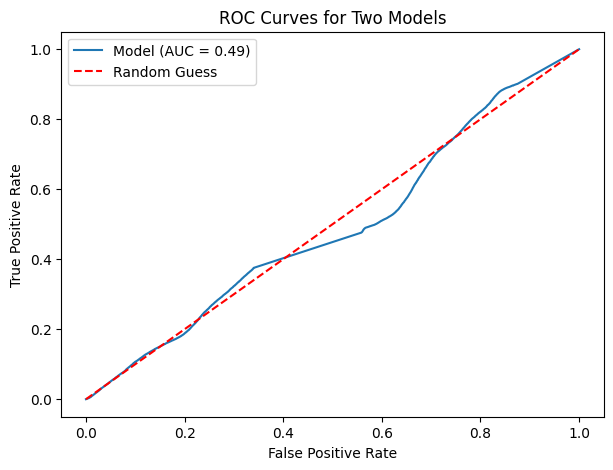

In [22]:


test_df = pd.DataFrame(
    {'True': y_test_np, 'Model': y_prob})

plt.figure(figsize=(7, 5))


fpr, tpr, _ = roc_curve(test_df['True'], test_df['Model'])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'Model (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Two Models')
plt.legend()
plt.show()

In [23]:


y_true = np.array([int(label) for label in y_test_np])  # true labels
y_pred = prediction                          # predicted class labels (e.g., from predict_batch)

# Precision, Recall, F1
precision = precision_score(y_true, y_pred, average='macro')  # Use 'binary' if binary task
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Overall Accuracy (OA)
oa = accuracy_score(y_true, y_pred)

# Average Accuracy (AA) — mean of per-class accuracies
cm = confusion_matrix(y_true, y_pred)
per_class_acc = cm.diagonal() / cm.sum(axis=1)
aa = per_class_acc.mean()

# Print all metrics
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"OA:        {oa:.4f}")
print(f"AA:        {aa:.4f}")

Precision: 0.5178
Recall:    0.5162
F1 Score:  0.5052
OA:        0.5162
AA:        0.5162


In [24]:

performance = {
    'AUC': float(roc_auc),
    'precision': float(precision),
    'recall': float(recall),
    'F1 Score': float(f1),
    'OA': float(oa),
    'AA': float(aa),
}
result_json = {
    'prediction' : scores,
    'performance' : performance,
}

In [25]:
import json
from datetime import datetime
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
print(result_json)

with open(f"performance/1DCNN {timestamp}_results.json", "w") as f:
    json.dump(result_json, f, indent=2)

print("JSON saved to results.json")

{'prediction': [{'dataset': 0, 'correct_0': 2390, 'correct_1': 3294, 'correct_total': 5684, 'total': 10000}, {'dataset': 1, 'correct_0': 2464, 'correct_1': 2491, 'correct_total': 4955, 'total': 10000}, {'dataset': 2, 'correct_0': 3940, 'correct_1': 1707, 'correct_total': 5647, 'total': 10000}, {'dataset': 3, 'correct_0': 4388, 'correct_1': 451, 'correct_total': 4839, 'total': 10000}, {'dataset': 4, 'correct_0': 1398, 'correct_1': 4023, 'correct_total': 5421, 'total': 10000}, {'dataset': 5, 'correct_0': 3839, 'correct_1': 1861, 'correct_total': 5700, 'total': 10000}, {'dataset': 6, 'correct_0': 3730, 'correct_1': 1310, 'correct_total': 5040, 'total': 10000}, {'dataset': 7, 'correct_0': 3734, 'correct_1': 1517, 'correct_total': 5251, 'total': 10000}, {'dataset': 8, 'correct_0': 3385, 'correct_1': 1343, 'correct_total': 4728, 'total': 10000}, {'dataset': 9, 'correct_0': 3993, 'correct_1': 365, 'correct_total': 4358, 'total': 10000}, {'dataset': 'Total Dataset', 'correct_0': 33261, 'correc

In [26]:
end_time = time.time()
print(f"Run time: {end_time - start_time:.4f} seconds")

Run time: 176.3210 seconds
